## Exercise 2 — Simulation of an Ideal CSTR

Following your team’s conceptual process design of the formic acid (FA) production plant last week, your company has requested a more detailed investigation of the reactor design before construction.  
Your task is to **develop the continuous stirred-tank reactor (CSTR)** model.

### Reactions

**Main reaction:**

$
A + B \xrightleftharpoons[\text{cat.}]{} 2C
$

**Side reactions:**

$
A + C \xrightleftharpoons[\text{cat.}]{} D
$

$
A + D \xrightleftharpoons[\text{cat.}]{} E
$


### Reactor Description

- The reactor is **cooled externally** via a double-jacket system.
- The **coolant** is maintained at a constant temperature.
- The **heterogeneous catalyst** is **immobilized** inside the reactor.


### Provided Python Functions

| Function | Description |
|-|-|
| `reaction_rate(x, T)` | Reaction rates of the three reactions (based on active sites) |
| `cp_l_molar(T)` | Molar heat capacities of components A–E |
| `delta_H_f_l()` | Standard enthalpies of formation of components A–E |


## Data & Assumptions

| Parameter | Value |
|--||
| Overall heat transfer coefficient | 1000 W/K |
| Coolant temperature | 283.15 K |
| Feed molar flow rate | 35 kmol/h |
| Mole fraction of A in feed | 0.5 mol/mol |
| Mole fraction of B in feed | 0.5 mol/mol |
| Catalyst capacity | 0.005 kmol<sub>active sites</sub>/kg<sub>cat</sub> |
| Operation | Steady-state |
| Mixing effects | Neglected |
| Pressure | Constant |
| Coolant temperature | Constant |
| Heat transfer coefficient | Constant |


### Importing Required Libraries

We begin by importing the essential Python libraries used throughout the notebook:

- **NumPy (`np`)** — provides efficient array operations and numerical computations.
- **Matplotlib (`plt`)** — used for creating visualizations and plotting simulation results.
- **Pandas (`pd`)** — facilitates structured data handling, especially for tabular datasets (e.g., simulation outputs).
- **SciPy Optimize (`least_squares`, `fsolve`)** — includes numerical solvers for nonlinear systems of equations:
  - `fsolve` is used for root-finding in general systems of equations.
  - `least_squares` provides a more stable and bounded approach, particularly suitable for ill-conditioned problems.
- **SciPy Integrate (`quad`)** — used for numerical integration.

Together, these tools form the computational foundation for modeling and analyzing the non-isothermal CSTR system.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares, fsolve
from scipy.integrate import quad

### Importing Instructor-Provided Functions

In the next step, we import several **predefined functions provided by the instructors**, which describe the key physical and chemical relationships in the system.  
These include, for example, functions for **reaction kinetics**, **molar heat capacities**, and **standard enthalpies of formation**.

Before using them in simulations, it is highly recommended to **carefully review the docstrings** of each function.  
The documentation specifies:
- what **input parameters** each function expects (including their **data types** and **units**),
- what **quantities** the function returns (and in what units),
- and how these outputs are intended to be used within the overall reactor model.

Understanding these definitions ensures that all parts of the model are **dimensionally consistent** and that the simulation results remain physically meaningful.

In [ ]:
def reaction_rate(x, T):
    
    """
    Calculate the reaction rates of three reversible reactions in a 
    pseudohomogeneous catalytic CSTR.

    The reaction scheme is:
        1) A + B <-> 2C        (main reaction)
        2) A + C <-> D         (first side reaction)
        3) A + D <-> E         (second side reaction)

    The function assumes that the kinetic rate law is expressed in 
    terms of *mole fractions* of the reacting species, not molar flows
    or concentrations. The kinetic constants follow Arrhenius behavior
    and the equilibrium constants are expressed as exponential functions 
    of temperature.

    Parameters:

    x : array_like of float, shape (5,)
        Mole fractions of components [A, B, C, D, E] at reactor conditions.
        Unitless (mol/mol). Must satisfy sum(x) = 1.
    T : float
        Temperature in the reactor, in Kelvin [K].

    Returns:

    r : ndarray of float, shape (3,)
        Reaction rates of the three reactions, evaluated per kmol of active
        sites on the catalyst:
            r[i]: rate of reaction i  [kmol_reaction / (kmol_active_sites·s)]

    Notes:

    - The pre-exponential factors k₀ are given in [kmol / (kmol_active_sites·s)].
    - The activation energies E_A are given in [kJ/kmol].
    - The gas constant R = 8.3145 kJ/(kmol·K).
    - The equilibrium constants K_x are dimensionless.

    The actual production or consumption rates of each component
    (in kmol/s) are obtained later by multiplying `r` with:
        m_cat * c_cat
    where:
        m_cat : catalyst mass [kg]
        c_cat : catalytic site concentration [kmol_active_sites / kg]

    Examples:
    
    >>> x = np.array([0.4, 0.4, 0.15, 0.04, 0.01])
    >>> T = 333.15  # K
    >>> r = reaction_rate(x, T)
    >>> print(r)
    [1.23e-05 2.45e-06 4.17e-07]
    """
    
    R = 8.3145  # kJ/(kmol*K)
    # Pre-exponential factors (kmol/(kmol_AZ*s))
    k_0_hin = np.array([2e5, 2e6, 1e9])
    # Activation energies (kJ/kmol)
    E_A = np.array([30, 40, 60]) * 1e3
    # Forward rate constants
    k_hin = k_0_hin * np.exp(-E_A / (R * T))
    # Equilibrium constants K_x
    A = np.array([-13.116, -0.6976, 4.7919])
    B = np.array([6013.590, 1202.718, -1202.718])
    K_x = np.exp(A + B / T)
    # Ensure x is a NumPy array
    x = np.asarray(x, dtype=float)
    # Reaction rates
    r = np.zeros(3)
    r[0] = k_hin[0] * (x[0] * x[1] - (1.0 / K_x[0]) * x[2]**2)
    r[1] = k_hin[1] * (x[0] * x[2] - (1.0 / K_x[1]) * x[3])
    r[2] = k_hin[2] * (x[0] * x[3] - (1.0 / K_x[2]) * x[4])

    return r

def cp_l_molar(T):
    """
    Calculate the molar heat capacities (Cp) of components A-E 
    as polynomial functions of temperature.

    The correlation uses a fourth-order polynomial:
        Cp_i(T) = A_i + B_i*T + C_i*T² + D_i*T³ + E_i*T⁴

    Parameters:
    
    T : float or array_like of float
        Temperature [K] at which to evaluate the molar heat capacities.
        Can be a scalar or a NumPy array.

    Returns:
    
    cp : ndarray of float, shape (5,)
        Molar heat capacities of components [A, B, C, D, E] 
        evaluated at the given temperature(s).
        Units: J / (kmol·K)

    Notes
    
    - The coefficients A-E correspond to the components in order [A, B, C, D, E].
    - The polynomial coefficients were fitted for liquid-phase heat capacities.
    - All calculations are performed in consistent SI units:
        T [K], Cp [J/(kmol·K)].
    - If an array of temperatures is provided, the function returns the 
      heat capacities evaluated for each T, flattened into a 1D array.

    Examples
    
    >>> T = 333.15  # K
    >>> cp = cp_l_molar(T)
    >>> print(cp)
    [132344. 203860. 239953.  75313. 290072.]

    >>> T = np.array([300, 400, 500])
    >>> cp = cp_l_molar(T)
    >>> print(cp.shape)
    (5,)
    """

   
    # Coefficients A to E
    A = np.array([115217.54, 274304.98918, 111850.07703, 276374.29551, 270720.66521])
    B = np.array([-140.55176, -1646.887138, 384.52026482, -2090.132486, -259.8306385])
    C = np.array([0.57619449, 5.5689045431, 0.0, 8.1251262837, 0.9542723448])
    D = np.array([0.0, -0.003782765, 0.0, -0.014116219, 0.0])
    E = np.array([0.0, 0.0, 0.0, 9.3702456e-6, 0.0])
    # Stack parameters into a 5x5 matrix
    Param_matrix = np.vstack([A, B, C, D, E])
    # Ensure T is a 1D numpy array
    T = np.atleast_1d(T).astype(float)
    # Build temperature matrix [1, T, T^2, T^3, T^4]
    T_matrix = np.vstack([T**i for i in range(5)]).T
    # Matrix multiplication 
    cp = T_matrix @ Param_matrix

    return np.array(cp).flatten()


def delta_H_f_l():
    """
    Return the standard molar enthalpies of formation for components A-E.

    These values correspond to the liquid phase at standard conditions 
    (usually 298.15 K and 1 bar). The data are used as reference enthalpies
    in energy balance calculations.

    Returns:

    Delta_H_f : ndarray of float, shape (5,)
        Standard molar enthalpies of formation for components 
        [A, B, C, D, E].
        Units: J/mol (here stored as J/kmol).

    Notes:

    - Values are given in J/kmol (obtained by multiplying kJ/mol × 1e6).
    - The components correspond to:
        A : Reactant 1
        B : Reactant 2
        C : Main product
        D : Side product 1
        E : Side product 2
    - Typical interpretation:
        Negative values → exothermic formation (stable compounds).
    - Used in combination with temperature-dependent enthalpy corrections 
      from `cp_l_molar(T)` in the energy balance.

    Examples:

    >>> delta_H_f = delta_H_f_l()
    >>> print(delta_H_f)
    [-1.00e+08 -8.00e+07 -1.15e+08 -2.25e+08 -3.15e+08]

    >>> # Enthalpy of formation of component C [J/kmol]
    >>> delta_H_f[2]
    -115000000.0
    """
    Delta_H_f = np.array([-100, -80, -115, -225, -315]) * 1e6
    
    return Delta_H_f

### Step 1: Modeling Conversion Slows — Starting with the Material Balance

To begin solving the non-isothermal CSTR problem, we first focus on **modeling the conversion behavior** — i.e., how the reactant and product concentrations change as the process proceeds.  
This is the foundation for understanding both the **reaction kinetics** and the **thermal dynamics** of the system.

We start by formulating and solving the **material balance equations**.  
These equations describe the steady-state molar flow rates of each component at the reactor outlet as a function of:
- the **feed composition and flow rate**,  
- the **stoichiometry** of the reactions,  
- the **reaction rates** (which depend on temperature and composition),  
- and the **mass and activity** of the catalyst.

Once the material balance is properly established and validated, it will serve as the basis for coupling with the **energy balance** in subsequent steps — allowing us to simulate the full conversion and temperature behavior of the reactor.

### Material balance (species balance) used in the code

At steady state, a CSTR’s species balance for each component *i* is written as:

$
0 = \dot n^{F}_{i} - \dot n^{P}_{i} + \sum_{j} \nu_{ij} R_j(T,\mathbf{x})
$

where:

- $\dot n^{F}_{i}$ — inlet molar flow of species *i* [kmol/s]  
- $\dot n^{P}_{i}$ — outlet molar flow of species *i* [kmol/s]  
- $\nu_{ij}$ — stoichiometric coefficient of species *i* in reaction *j* (negative for reactants, positive for products)  
- $R_j$ — overall molar production (or consumption) rate of reaction *j* in the reactor [kmol/s]

In a pseudohomogeneous catalytic model, the overall reaction rate is derived from an intrinsic rate $r_j(T, \mathbf{x})$ (expressed per “active site” or per unit catalyst) and scaled to the reactor level via:

$
R_j = r_j(T, \mathbf{x}) \cdot \frac{m_{\text{cat}}}{c_{\text{cat}}}
$

so that the resulting units correspond to [kmol/s].  
If the intrinsic rate law is defined per mass or volume of catalyst, this scaling term must be adjusted accordingly.

### Function details

#### • Inputs
- **P_out** — current guess of outlet molar flows ([A, B, C, D, E]) in *kmol/s*.  
- **F_in** — inlet molar flows in *kmol/s* (same order).  
- **T_reactor** — reactor temperature *K* used by the kinetic model.  
- **stoch_matrix** — $(5 \times 3)$ matrix of $(\nu_{ij})$ (components × reactions).  
- **m_catalist**, **cat_capacity** — catalyst scaling factors converting intrinsic rates to *[kmol/s]*.

#### • Kinetics input as mole fractions  
The intrinsic kinetic law `reaction_rate(x, T)` expects **mole fractions** $x_i$ (dimensionless), not molar flows.  
Therefore, the code converts the guessed outlet flows to a normalized composition:

$
\mathbf{x} = \frac{\mathbf{P}_{\text{out}}}{\sum_k P_{\text{out},k}}
$

and then calls `reaction_rate(x, T_reactor)`.

#### • Residual it returns  
The function does **not** solve the balance itself. It returns the 5-element vector of **imbalances**:

$
\mathbf{r}^{\text{mat}} = \mathbf{P}_{\text{out}} - \mathbf{F}_{\text{in}} - \nu \cdot \mathbf{r}(T,\mathbf{x}) \cdot \frac{m_{\text{cat}}}{c_{\text{cat}}}
$

This represents the left-hand side of the steady-state material balance.  
A nonlinear solver (such as `fsolve` or `least_squares`) then adjusts $\mathbf{P}_{\text{out}}$ (and, if coupled, $T$) until the residual vector approaches zero.

#### • Units and consistency checks
- $F_{\text{in}}, P_{\text{out}}$ → [kmol/s]  
- $\nu$ → dimensionless  
- `reaction_rate` → must be consistent with the scaling $\frac{m_{\text{cat}}}{c_{\text{cat}}}$ so that $\nu \, r \, \frac{m_{\text{cat}}}{c_{\text{cat}}}$ has units of [kmol/s]  
- `reaction_rate` should accept **mole fractions** and **temperature [K]**

#### • Why formulate as a residual?  
Numerical solvers require a function $\mathbf{f}(\mathbf{z})$ that becomes **zero at the solution**.  
By expressing the material balance in residual form, the solver can directly iterate on the unknown outlet flows $\mathbf{P}_{\text{out}}$ (and optionally $T$) until:

$
\mathbf{r}^{\text{mat}} \approx 0
$

indicating that the steady-state mass balance is satisfied within the numerical tolerance.

In [57]:
def matherial_balance(P_out, F_in, T_reactor, stoch_matrix, m_catalist, cat_capacity):

    reaction_rates = reaction_rate(P_out / np.sum(P_out), T_reactor)

    residual = P_out - F_in - np.dot(stoch_matrix, reaction_rates) * m_catalist / cat_capacity
    
    return residual

### From component balances to **reaction extents**

In the **component-based** formulation we write a material balance for each species.
With 5 components (A–E) this yields **five equations**:

$$
\mathbf{r}^{\text{mat}}(\mathbf{P}_{\text{out}}, T)
= \mathbf{P}_{\text{out}} - \mathbf{F}_{\text{in}}
- \nu\,\mathbf{r}(T, \mathbf{x})\,\frac{m_{\text{cat}}}{c_{\text{cat}}}
= \mathbf{0},
\qquad \mathbf{P}_{\text{out}} \in \mathbb{R}^{5}.
$$

Here $\nu\in\mathbb{R}^{5\times 3}$ is the stoichiometric matrix and
$\mathbf{r}(T,\mathbf{x})\in\mathbb{R}^{3}$ are intrinsic reaction rates.

#### Reaction–extent formulation (ξ–formulation)

Instead of balancing each component, we balance **each reaction** via its extent
$\boldsymbol{\xi} = (\xi_1,\xi_2,\xi_3)^\top$.
The outlet flows are reconstructed from the feed by the stoichiometry:

$
\mathbf{F}_{\text{out}}(\boldsymbol{\xi}) \;=\; \mathbf{F}_{\text{in}} + \nu\,\boldsymbol{\xi}.
$

At steady state the reaction progress is linked to kinetics via the catalyst:

$
\boldsymbol{\xi} \;=\; m_{\text{cat}}\,c_{\text{cat}}\,\mathbf{r}(T,\mathbf{x}),
\quad \text{with}\quad
\mathbf{x}=\frac{\mathbf{F}_{\text{out}}(\boldsymbol{\xi})}{\sum_i F_{\text{out},i}(\boldsymbol{\xi})}.
$

This gives **only 3 equations** (one per reaction) for the unknown extents (and,
if coupled, temperature). The energy balance can then be added as a single
additional equation in $T$.

#### Why this helps

- **Fewer equations:** 5 component balances → **3 reaction balances**.
  Removing redundant constraints typically improves the **conditioning** of the
  nonlinear system and helps solvers converge more reliably.
- **Built-in consistency:** Stoichiometry is enforced exactly by
  $\mathbf{F}_{\text{out}}=\mathbf{F}_{\text{in}}+\nu\,\boldsymbol{\xi}$.
- **Cleaner coupling to energy:** The heat balance depends on
  $\mathbf{F}_{\text{out}}(\boldsymbol{\xi})$ and $T$; solving in $(\boldsymbol{\xi},T)$
  keeps the structure tight and avoids overdetermination.
- **Natural nonnegativity:** It is straightforward to clip or bound
  $\mathbf{F}_{\text{out}}(\boldsymbol{\xi})$ to keep flows physical.

#### Summary of the “bridge”

- Component form: solve for $\mathbf{P}_{\text{out}}\in\mathbb{R}^{5}$ (plus $T$) with 5 balances.
- Extent form: solve for $\boldsymbol{\xi}\in\mathbb{R}^{3}$ (plus $T$) with 3 balances, then
  compute $\mathbf{F}_{\text{out}}$ from stoichiometry.
- Both are mathematically equivalent, but the **extent formulation is leaner** and
  usually **easier to solve numerically**—exactly the advantage highlighted in the lectures.

### Material balance in terms of **Reaction Extents**

The idea of the **extent-based material balance** is to formulate the mass balance
not for individual *components*, but for each **reaction** taking place in the reactor.  
Instead of directly balancing 5 species, we describe the system using **3 reaction
extents** — one for each independent chemical reaction.

#### Core relationship

At steady state, the outlet molar flow of each component is related to the feed
composition and the reaction extents by the stoichiometric matrix $\nu$:

$$
\boldsymbol{F}_{\text{out}}
\;=\;
\boldsymbol{F}_{\text{in}} + \nu\,\boldsymbol{\xi},
\qquad
\nu \in \mathbb{R}^{5\times 3}, \;
\boldsymbol{\xi} = 
\begin{bmatrix}
\xi_1 \\[3pt] \xi_2 \\[3pt] \xi_3
\end{bmatrix}.
$$

Here, each $\xi_j$ represents the **extent of reaction** $j$,
i.e. how many kmoles of reaction $j$ have proceeded in the reactor.


#### Kinetic link

The key physical assumption is that the observed reaction extents correspond
to the total amount of material that has reacted over the catalyst volume.
We equate this with the intrinsic kinetic rate multiplied by catalyst properties:

$$
\boldsymbol{\xi}
\;=\;
m_{\text{cat}}\,c_{\text{cat}}\,\boldsymbol{r}(T,\boldsymbol{x}),
$$

where  
- $m_{\text{cat}}$ — catalyst mass [kg],  
- $c_{\text{cat}}$ — catalyst active-site capacity [kmol active sites/kg],  
- $\boldsymbol{r}(T,\boldsymbol{x})$ — intrinsic reaction rate vector [kmol/(kmolₐₛ·s)].  

Thus, each extent $\xi_j$ represents the total **amount of reaction** $j$ that has occurred,
scaled by the catalytic activity.

#### Residual form

Numerically, the solver handles this by driving the following **residuals** to zero:

$$
\boldsymbol{r}^{\text{mat}}_{\xi}
=
\frac{
\boldsymbol{\xi}
-
m_{\text{cat}}\,c_{\text{cat}}\,\boldsymbol{r}(T,\boldsymbol{x})
}{
\max(|\boldsymbol{\xi}|, 1)
}
\;=\;
\boldsymbol{0}.
$$

The normalization by $\max(|\boldsymbol{\xi}|, 1)$ is purely numerical and ensures
that all equations remain within a similar scale, improving convergence.


#### Summary

This formulation expresses the **material balance via reaction progress** rather
than component accumulation.  
It drastically reduces the dimensionality of the problem (from 5 component
balances to 3 reaction balances) while maintaining the same physical meaning:
each extent $\xi_j$ quantifies **how much substance has reacted** in reaction $j$.

In [58]:
def material_balance_extents(vars_, F_in, stoch_matrix, m_catalist, cat_capacity):
    """
    Material balance reformulated via extents of reaction.

    Solves for ξ_1, ξ_2, ξ_3 and T such that:
        ξ_i = m_cat * c_cat * r_i(x, T)
    and component flows satisfy:
        F_out = F_in + ν * ξ

    Parameters

    vars_ : array-like, shape (4,)
        Unknowns: [ξ₁, ξ₂, ξ₃, T]
    F_in : ndarray, shape (5,)
        Feed molar flows of components [kmol/s].
    stoch_matrix : ndarray, shape (5, 3)
        Stoichiometric coefficients (components x reactions).
    m_catalist : float
        Catalyst mass [kg].
    cat_capacity : float
        Catalyst active site concentration [kmol_active_sites/kg].

    Returns

    residuals : ndarray, shape (4,)
        3 material residuals for reaction extents, + 1 placeholder for energy balance (if needed).
    """

    reaction_extends = np.asarray(vars_[:3], dtype=float)
    
    T = float(vars_[3])

    F_out = F_in + stoch_matrix @ reaction_extends

    x = np.clip(F_out / max(F_out.sum(), 1e-16), 1e-12, 1.0)
    
    x /= x.sum()

    r = reaction_rate(x, T)

    scale_factor = np.maximum(np.abs(reaction_extends).max(), 1.0)
    
    res_mass = (reaction_extends - m_catalist * cat_capacity * r) / scale_factor

    return res_mass

### Energy (Heat) Balance for a Non-Isothermal CSTR

The **energy balance** complements the material balance by accounting for the heat
effects arising from both chemical reactions and heat exchange with the cooling jacket.

#### Steady-State Formulation

At steady state, the rate of heat removed (or supplied) must equal the net enthalpy
change of all inlet and outlet process streams:

$$
Q + \sum_i F_{\text{out},i}\,H_i(T_{\text{out}})
- \sum_i F_{\text{in},i}\,H_i(T_{\text{in}}) = 0
$$

where

$$
Q = U \, (T - T_{\text{cool}})
$$  
— heat flux through the reactor wall [J/s].

$$
H_i(T) = \Delta H_{f,i} + \int_{273}^{T} c_{p,i}(T')\,dT'
$$  
— molar enthalpy of component \( i \) [J/kmol].

$$
F_{\text{in},i}, \; F_{\text{out},i}
$$  
— molar flow rates [kmol/s].



The first term

$$
Q = U (T - T_{\text{cool}})
$$  

represents **heat removed by the cooling jacket** when  

$$
T > T_{\text{cool}}.
$$

The remaining terms describe the **enthalpy change** due to both the chemical reaction
and the temperature difference between the inlet and outlet streams.

#### Sign Convention

It is crucial to maintain consistent sign conventions throughout the model.

$$
Q > 0
$$  
Heat is **removed** from the reactor (cooling).

$$
H_{\text{out}} > H_{\text{in}}
$$  
The process streams **gain enthalpy**, corresponding to an **endothermic** process.

The steady-state energy balance residual can thus be written as:

$$
r^{\text{heat}} = H_{\text{out}} - H_{\text{in}} + Q = 0
$$

When this residual approaches zero, the energy balance is satisfied.

#### Scaling (Normalization)

Because enthalpy flows are typically very large — on the order of

$$
10^5 \text{–} 10^7 \; \text{J/s},
$$

direct computation may lead to **numerical instability** in iterative solvers.
To improve numerical conditioning, the residual is normalized by an appropriate scaling factor:

$$
r^{\text{heat}}_{\text{scaled}} =
\frac{H_{\text{out}} - H_{\text{in}} + Q}
{\max(|H_{\text{out}} - H_{\text{in}}|,\,10^{-3})}
$$

This normalization does **not** change the physical meaning of the balance — it only improves solver stability for iterative methods such as `fsolve` or `least_squares`.

#### Practical Notes

The following implementation details are important for numerical stability and correctness:

1. The integral of the molar heat capacity is computed numerically:

   $$
   \int_{273}^{T} c_p(T') \, dT'
   $$

   using the `scipy.integrate.quad` routine.

2. The standard enthalpies of formation are taken from tabulated thermodynamic data.

3. Always **verify sign conventions** carefully.  
   This is especially critical in **exothermic** systems, where the direction of heat flow
   (whether \( Q \) is positive or negative) determines the physical interpretation of the results.

#### Summary

This heat balance ensures that the **total heat removed or supplied** equals the **enthalpy change**
of the reacting mixture.  
When coupled with the material balances, it enables determination of the reactor outlet temperature
and provides full thermal characterization of the non-isothermal CSTR.

In [59]:
def heat_balance(T, T_cool, T_in, F_in, P_out, U):
    """
    Compute the steady-state energy (heat) balance for a non-isothermal CSTR.

    The function evaluates the residual of the reactor heat balance, i.e. the
    difference between the heat removed through the cooling jacket and the 
    net enthalpy change of the process streams.

    The steady-state energy balance is expressed as:
        Q + Σ(F_out_i * H_i(T_out)) - Σ(F_in_i * H_i(T_in)) = 0

    Parameters

    T : float
        Reactor outlet temperature [K].
    T_cool : float
        Coolant (jacket) temperature [K].
    T_in : float
        Feed (inlet) temperature [K].
    F_in : array_like of float, shape (5,)
        Inlet molar flow rates of components [A, B, C, D, E], [kmol/s].
    P_out : array_like of float, shape (5,)
        Outlet molar flow rates of components [A, B, C, D, E], [kmol/s].
    U : float
        Overall heat transfer coefficient multiplied by heat exchange area [W/K].
        (Note: Q = U * (T - T_cool))

    Returns

    residual : float
        Residual of the energy balance [J/s].
        At steady state, residual → 0.

    Notes

    - Molar enthalpy of each component is computed as:
          h_i(T) = ΔH_f_i + ∫(cp_i(T') dT') from 273 K to T
    - The standard enthalpies of formation ΔH_f_i are obtained 
      from `delta_H_f_l()` [J/kmol].
    - The molar heat capacities cp_i(T) are evaluated using `cp_l_molar(T)` [J/(kmol·K)].
    - The integral of cp_i(T) is computed numerically via `scipy.integrate.quad`.

    - Sign convention:
        * Q > 0  → heat removed from reactor (cooling)
        * residual = Q + H_out - H_in
          → residual = 0 corresponds to energy balance satisfied.

    Examples

    >>> T = 340.0
    >>> T_cool = 283.15
    >>> T_in = 333.15
    >>> U = 1000.0
    >>> F_in = np.array([0.0049, 0.0049, 0, 0, 0])
    >>> P_out = np.array([0.0048, 0.0048, 0.0001, 0, 0])
    >>> res = heat_balance(T, T_cool, T_in, F_in, P_out, U)
    >>> print(f"Residual = {res:.3e} J/s")
    """

    Q = U * (T - T_cool)


    integrated_Cp_in = np.array([
    quad(lambda T: cp_l_molar(T)[i], 273, T_in)[0]
    for i in range(5)
    ])

    H_in = np.dot(F_in, (delta_H_f_l() + integrated_Cp_in)) 


    integrated_Cp_out = np.array([
    quad(lambda T: cp_l_molar(T)[i], 273, T)[0]
    for i in range(5)
    ])

    H_out = np.dot(P_out, (delta_H_f_l() + integrated_Cp_out))

    scaling_factor = 1.0 if np.abs(H_out - H_in) <= 1e-3 else np.abs(H_out - H_in)

    residual = (H_out - H_in + Q) / scaling_factor

    return residual

### Coupled Material and Energy Balances — CSTR System Definition

At this stage, both the **material** and **energy** balances are combined into a single system of nonlinear algebraic equations, represented by the function `cstr_equations_extents`.

We solve simultaneously for the **three reaction extents** $\xi_1,\;\xi_2,\;\xi_3$ and the **reactor temperature** $T$.

#### Purpose of the combined residual

SciPy solvers (`fsolve`, `least_squares`) require a callable that returns a **vector of residuals** which becomes zero at the solution. We therefore define

$$
\mathbf{r}(\xi_1,\xi_2,\xi_3,T)
=
\begin{bmatrix}
r_{\xi_1}\\[2pt]
r_{\xi_2}\\[2pt]
r_{\xi_3}\\[2pt]
r_{\text{heat}}
\end{bmatrix}
=
\begin{bmatrix}
\boldsymbol{\xi} \;-\; m_{\text{cat}}\,c_{\text{cat}}\;\mathbf{r}_{\text{kin}}(T,\mathbf{x}) \\[6pt]
H_{\text{out}} \;-\; H_{\text{in}} \;+\; Q
\end{bmatrix}
= \mathbf{0}.
$$

#### Why this structure helps

- The solver **adjusts all unknowns together** so temperature–composition coupling is handled consistently.
- Writing balances as residuals makes them **plug-and-play** for root/least-squares solvers.
- Using extents reduces the material system from **5 component equations** to **3 reaction equations**, which generally improves conditioning and convergence.

In [60]:
def cstr_equations_extents(vars_, F_in, stoch_matrix, m_catalist, cat_capacity, T_cool, T_in, U):
    """
    Coupled system of material (via reaction extents) and energy balances
    for a non-isothermal CSTR.

    Unknowns:
        vars_ = [xi1, xi2, xi3, T]

    Material balances (via extents):
        F_out = F_in + nu @ xi
        xi = m_cat * c_cat * r(x, T)
      The function `material_balance_extents` returns the 3 residuals for xi.

    Energy balance (already scaled inside your `heat_balance`):
        residual_heat = (H_out - H_in - Q) / scaling_factor

    Parameters

    vars_ : array-like, shape (4,)
        [xi1, xi2, xi3, T].
    F_in : ndarray, shape (5,)
        Inlet molar flows [kmol/s].
    stoch_matrix : ndarray, shape (5, 3)
        Stoichiometric matrix (components x reactions).
    m_catalist : float
        Catalyst mass [kg].
    cat_capacity : float
        Active site concentration [kmol_active_sites/kg].
    T_cool : float
        Coolant temperature [K].
    T_in : float
        Feed temperature [K].
    U : float
        Overall heat transfer coefficient x area [W/K].

    Returns

    residuals : ndarray, shape (4,)
        [res_xi1, res_xi2, res_xi3, res_energy]
    """

    # Unpack unknowns
    xi = np.asarray(vars_[:3], dtype=float)
    T  = float(vars_[3])

    # 2Material residuals (3 eqs) — uses your normalization inside
    res_mass = material_balance_extents(vars_, F_in, stoch_matrix, m_catalist, cat_capacity)

    #  Outlet flows (needed for heat balance)
    F_out = F_in + stoch_matrix @ xi

    # Energy residual — already scaled inside your heat_balance
    res_heat = heat_balance(T, T_cool, T_in, F_in, F_out, U)

    # 5) Combine residuals
    return np.append(res_mass, res_heat)

### Transition to the Problem Solving Stage

Having derived and implemented all necessary balance equations — both **material** and **energy**,  
and having ensured their numerical stability and physical consistency,  
we can now proceed to the **actual problem-solving stage**.

Let’s now move step by step through the solution of each task.

## Tasks

### 1. Outlet composition vs. Catalyst mass

Compute **outlet concentrations** of all reactants and the **outlet temperature** of the CSTR as a function of catalyst mass: 

$
0.05 \, \text{kg} < m_{cat} < 10 \, \text{kg}
$  

for a feed temperature of 

$
T_{in} = 333.15 \, \text{K}
$  

Plot:
- Outlet concentrations vs. \( m_{cat} \)
- Outlet temperature vs. \( m_{cat} \)

In [61]:
# Data and assumptions

stoch_matrix = np.array([
    [-1, -1, -1],  # A
    [-1,  0,  0],  # B
    [ 2, -1,  0],  # C
    [ 0,  1, -1],  # D
    [ 0,  0,  1]   # E
]) # (1) (2) (3)

feed_molar_flow_total = 35 / 3600  # kmol/h -> kmol/s
n_feed = np.array([0.5, 0.5, 0, 0, 0])
F_in = n_feed * feed_molar_flow_total  # (5,)
T_in = 333.15
T_cool = 283.15
U = 1000
cat_capacity = 0.005


### Solving the Material and Energy Balance System as a Function of Catalyst Mass

To study how the outlet composition and reactor temperature depend on the **catalyst mass**, we define a range of catalyst weights (`masses`) and iteratively solve the coupled system of material and energy balances for each value.

At each iteration, the nonlinear system is solved using `scipy.optimize.fsolve`, which searches for the roots of the function `cstr_equations_extents`. This function returns four residuals — three for the material balances (formulated through  
reaction extents) and one for the heat balance.

The approach uses a **continuation strategy**, where each new iteration starts from the previous solution (`x0`). This method stabilizes convergence and helps the solver follow the physical solution branch as the catalyst mass increases.

#### Why the initial guess (`x0`) matters

Root-finding solvers such as `fsolve` are **highly sensitive to the initial guess**. They approximate local derivatives and can easily diverge or converge to non-physical roots if `x0` is poorly chosen.

It is strongly recommended to **experiment with different initial guesses** — for example, modifying the initial temperature or reaction extents — to see how the solver behaves. This illustrates how nonlinear systems can produce unstable or unrealistic results when started far from the correct physical solution.

In [62]:
# Catalyst mass range
masses = np.arange(0.05, 10.05, 0.05)  # [kg]

# Initial guess for [ξ1, ξ2, ξ3, T]
x0 = np.array([0.0, 0.0, 0.0, 320.15], dtype=float)

# DataFrame to store results
results_task1 = pd.DataFrame(
    columns=['mass_catalist',
            'A_out_rate', 
            'B_out_rate', 
            'C_out_rate', 
            'D_out_rate', 
            'E_out_rate',
            'A_out_molar_fraction', 
            'B_out_molar_fraction', 
            'C_out_molar_fraction', 
            'D_out_molar_fraction', 
            'E_out_molar_fraction',  
            'T_out']
)

# Iterate over catalyst mass values
for m_catalist in masses:

    # Solve the nonlinear system of material + energy balances
    sol = fsolve(
        func=cstr_equations_extents,          # coupled balance equations
        x0=x0,                                # initial guess [ξ1, ξ2, ξ3, T]
        args=(F_in, stoch_matrix, m_catalist, cat_capacity, T_cool, T_in, U),
        xtol=1e-10,                           # solver tolerance
        maxfev=5000,                          # maximum number of iterations
        full_output=True                      # request solver diagnostics
    )

    # Unpack fsolve outputs
    x_sol, info, ier, msg = sol
    xi = x_sol[:3]                            # reaction extents
    T = x_sol[3]                              # reactor temperature

    # Recover outlet molar flows
    F_out = F_in + stoch_matrix @ xi          # F_out = F_in + ν·ξ
    A_out, B_out, C_out, D_out, E_out = F_out
    
    F_out_molar = F_out / np.sum(F_out)
    A_out_molar, B_out_molar, C_out_molar, D_out_molar, E_out_molar = F_out_molar
    # Diagnostics: residual norm and reaction rates
    res_norm = np.linalg.norm(info['fvec'])   # overall residual magnitude
    x_mf = F_out / F_out.sum()                # outlet mole fractions
    r_test = reaction_rate(x_mf, T)           # verify kinetic rates

    print(f"m_cat={m_catalist:.2f} kg  ||res||={res_norm:.3e}  "
          f"T={T:.2f} K  rates={r_test}")

    # Save results to the DataFrame
    results_task1.loc[len(results_task1)] = [
        m_catalist, A_out, B_out, C_out, D_out, E_out, A_out_molar, B_out_molar, C_out_molar, D_out_molar, E_out_molar, T
    ]

    # Update initial guess for next iteration (continuation strategy)
    x0 = x_sol.copy()

m_cat=0.05 kg  ||res||=5.168e-12  T=316.06 K  rates=[5.21756164e-01 6.36008921e-03 9.63580884e-06]
m_cat=0.10 kg  ||res||=6.129e-14  T=318.41 K  rates=[5.35069490e-01 1.40584542e-02 4.87693912e-05]
m_cat=0.15 kg  ||res||=8.916e-14  T=320.85 K  rates=[5.47349538e-01 2.32279512e-02 1.38501740e-04]
m_cat=0.20 kg  ||res||=4.709e-13  T=323.38 K  rates=[5.58236183e-01 3.39538628e-02 3.09224102e-04]
m_cat=0.25 kg  ||res||=1.436e-12  T=325.98 K  rates=[0.56736101 0.04624635 0.00060202]
m_cat=0.30 kg  ||res||=2.063e-14  T=328.64 K  rates=[0.57436202 0.06001034 0.0010683 ]
m_cat=0.35 kg  ||res||=4.335e-13  T=331.34 K  rates=[0.5788988  0.07501624 0.00176618]
m_cat=0.40 kg  ||res||=8.051e-13  T=334.04 K  rates=[0.58067232 0.09087854 0.00275168]
m_cat=0.45 kg  ||res||=4.359e-12  T=336.71 K  rates=[0.57945597 0.10705495 0.00406446]
m_cat=0.50 kg  ||res||=1.648e-11  T=339.30 K  rates=[0.57514135 0.12288287 0.00571032]
m_cat=0.55 kg  ||res||=7.475e-16  T=341.79 K  rates=[0.56778899 0.13766367 0.00764

The computed results for each catalyst mass are stored in a **Pandas DataFrame**, allowing easy access, analysis, and visualization of the outlet compositions and reactor temperatures.  

In [63]:
results_task1

,mass_catalist,A_out_rate,B_out_rate,C_out_rate,D_out_rate,E_out_rate,A_out_molar_fraction,B_out_molar_fraction,C_out_molar_fraction,D_out_molar_fraction,E_out_molar_fraction,T_out
0,0.05,0.004729,0.004731,0.000259,0.000002,2.408952e-09,0.486499,0.486663,0.026674,0.000163,2.478185e-07,316.063492
1,0.10,0.004587,0.004594,0.000528,0.000007,2.438470e-08,0.472099,0.472825,0.054352,0.000721,2.509961e-06,318.409809
2,0.15,0.004433,0.004451,0.000804,0.000017,1.038763e-07,0.456797,0.458603,0.082806,0.001784,1.070371e-05,320.852200
3,0.20,0.004269,0.004303,0.001083,0.000034,3.092241e-07,0.440610,0.444147,0.111739,0.003473,3.191839e-05,323.381330
4,0.25,0.004093,0.004152,0.001361,0.000057,7.525208e-07,0.423582,0.429641,0.140795,0.005904,7.787119e-05,325.984288
...,...,...,...,...,...,...,...,...,...,...,...,...
195,9.80,0.000367,0.002264,0.003548,0.001394,2.517324e-04,0.046906,0.289392,0.453387,0.178144,3.217103e-02,370.350523
196,9.85,0.000366,0.002264,0.003548,0.001394,2.517098e-04,0.046837,0.289389,0.453392,0.178212,3.216986e-02,370.358899
197,9.90,0.000366,0.002264,0.003547,0.001395,2.516871e-04,0.046769,0.289386,0.453396,0.178280,3.216866e-02,370.367194
198,9.95,0.000365,0.002264,0.003547,0.001395,2.516644e-04,0.046701,0.289384,0.453400,0.178348,3.216744e-02,370.375409


Next, we visualize the model results by plotting how the **outlet molar flows** of each component  and the **reactor temperature** change as a function of the **catalyst mass**.

These plots help reveal how increasing catalyst loading affects both the **conversion**  and the **thermal behavior** of the reactor.

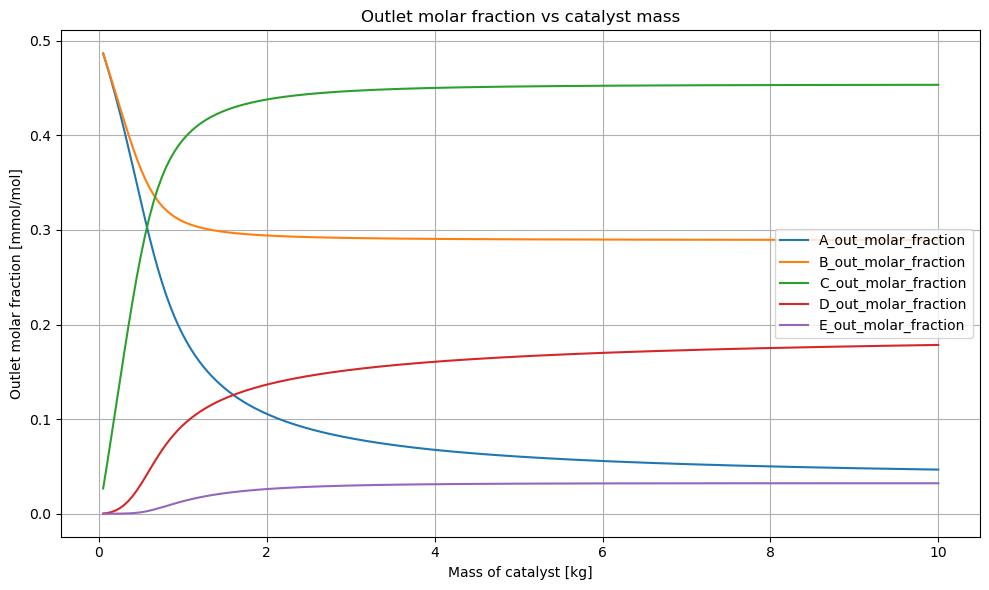

In [64]:
cols_to_plot = [
    'A_out_molar_fraction', 
    'B_out_molar_fraction', 
    'C_out_molar_fraction', 
    'D_out_molar_fraction', 
    'E_out_molar_fraction'
]

plt.figure(figsize=(10, 6))

for col in cols_to_plot:
    plt.plot(
        results_task1['mass_catalist'], 
        results_task1[col], 
        label=col
    )

plt.xlabel("Mass of catalyst [kg]")
plt.ylabel("Outlet molar fraction [mmol/mol]")
plt.title("Outlet molar fraction vs catalyst mass")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.show()

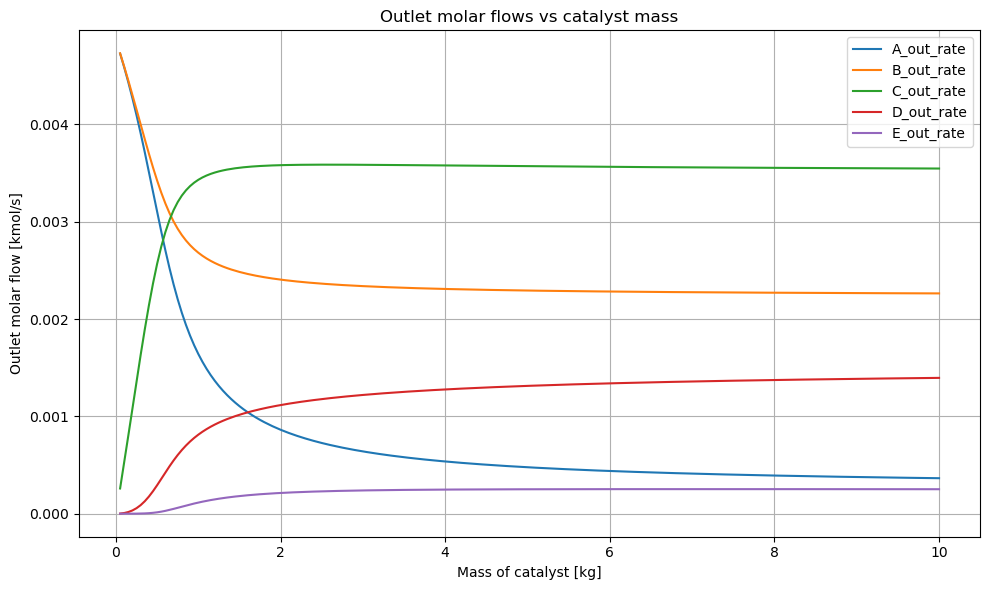

In [65]:
cols_to_plot = ['A_out_rate', 'B_out_rate', 'C_out_rate', 'D_out_rate', 'E_out_rate']

plt.figure(figsize=(10, 6))

for col in cols_to_plot:
    plt.plot(
        results_task1['mass_catalist'], 
        results_task1[col], 
        label=col
    )

plt.xlabel("Mass of catalyst [kg]")
plt.ylabel("Outlet molar flow [kmol/s]")
plt.title("Outlet molar flows vs catalyst mass")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

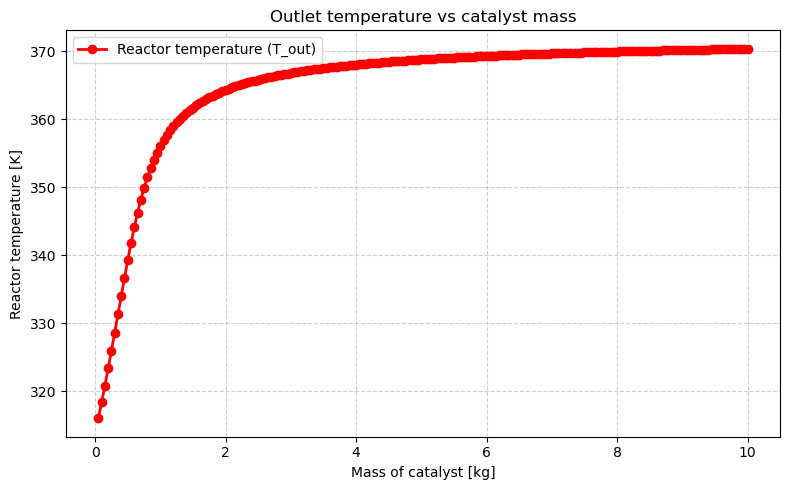

In [66]:
plt.figure(figsize=(8, 5))

plt.plot(
    results_task1['mass_catalist'],
    results_task1['T_out'],
    color='red',
    linewidth=2,
    marker='o',
    label='Reactor temperature (T_out)'
)

plt.xlabel("Mass of catalyst [kg]")
plt.ylabel("Reactor temperature [K]")
plt.title("Outlet temperature vs catalyst mass")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 2. Outlet composition vs. Feed temperature

Compute **outlet concentrations** and **outlet temperature** as a function of **feed temperature**:

$
333.15 \, \text{K} < T_{in} < 393.15 \, \text{K}
$  

for a fixed catalyst mass of 

$
m_{cat} = 1 \, \text{kg}
$  

Plot:
- Outlet concentrations vs. \( T_{in} \)
- Outlet temperature vs. \( T_{in} \)



In [67]:
# Data and assumptions
m_catalist = 1.0  

The solution strategy for the **second task** is identical to the previous one.  The only difference is that, instead of iterating over the **catalyst mass**, we now vary the **feed temperature** and solve the same coupled material and energy balance equations for each value. This allows us to study how the reactor's outlet composition and temperature respond to changes in the inlet temperature conditions.

In [68]:
# Inlet temperature range
temperatures = np.arange(333.15, 393.15, 0.1)

# Initial guess for [ξ1, ξ2, ξ3, T]
x0 = np.array([0.00227212, 0.00122259, 0.00023433, 333.15])  # [ξ₁, ξ₂, ξ₃, T]

# DataFrame to store results
results_task2 = pd.DataFrame(
    columns=['feed_temperature',
            'A_out_rate', 
            'B_out_rate', 
            'C_out_rate', 
            'D_out_rate', 
            'E_out_rate',
            'A_out_molar_fraction', 
            'B_out_molar_fraction', 
            'C_out_molar_fraction', 
            'D_out_molar_fraction', 
            'E_out_molar_fraction',  
            'T_out']
)

for T_in in temperatures:
    sol = fsolve(
        func=cstr_equations_extents,         # system of equations
        x0=x0,                               # initial guess
        args=(F_in, stoch_matrix, m_catalist, cat_capacity, T_cool, T_in, U),
        xtol=1e-10,                          # tolerance
        maxfev=5000,                         # iteration cap
        full_output=True                     # so we can check convergence info
    )

    x_sol, info, ier, msg = sol             
    xi = x_sol[:3]
    T = x_sol[3]

    # Compute outlet molar flows
    F_out = np.clip(F_in + stoch_matrix @ xi, 1e-12, None)
    A_out, B_out, C_out, D_out, E_out = F_out

    F_out_molar = F_out / np.sum(F_out)
    A_out_molar, B_out_molar, C_out_molar, D_out_molar, E_out_molar = F_out_molar

    # Diagnostic info
    res_norm = np.linalg.norm(info['fvec'])
    x_mf = F_out / F_out.sum()
    r_test = reaction_rate(x_mf, T)


    print(f"T_in={T_in:.2f} K ||res||={res_norm:.3e} T={T:.2f} K rates={r_test}")


    # Save results to the DataFrame
    results_task2.loc[len(results_task2)] = [
        T_in, A_out, B_out, C_out, D_out, E_out, A_out_molar, B_out_molar, C_out_molar, D_out_molar, E_out_molar, T
    ]

    # Update initial guess for next iteration
    x0 = x_sol


T_in=333.15 K ||res||=5.949e-12 T=356.07 K rates=[0.43575254 0.18527021 0.02286711]
T_in=333.25 K ||res||=4.365e-14 T=356.16 K rates=[0.43593072 0.18558592 0.02296341]
T_in=333.35 K ||res||=4.539e-14 T=356.24 K rates=[0.43610785 0.18590095 0.02305978]
T_in=333.45 K ||res||=4.613e-14 T=356.33 K rates=[0.43628394 0.1862153  0.02315622]
T_in=333.55 K ||res||=4.409e-14 T=356.42 K rates=[0.43645897 0.18652898 0.02325274]
T_in=333.65 K ||res||=4.364e-14 T=356.50 K rates=[0.43663297 0.18684199 0.02334934]
T_in=333.75 K ||res||=4.042e-14 T=356.59 K rates=[0.43680593 0.18715433 0.023446  ]
T_in=333.85 K ||res||=4.077e-14 T=356.68 K rates=[0.43697786 0.18746599 0.02354274]
T_in=333.95 K ||res||=4.092e-14 T=356.76 K rates=[0.43714875 0.18777699 0.02363954]
T_in=334.05 K ||res||=4.344e-14 T=356.85 K rates=[0.43731861 0.18808731 0.02373642]
T_in=334.15 K ||res||=4.161e-14 T=356.94 K rates=[0.43748745 0.18839696 0.02383336]
T_in=334.25 K ||res||=4.334e-14 T=357.02 K rates=[0.43765527 0.18870594 0.02

In [69]:
results_task2

,feed_temperature,A_out_rate,B_out_rate,C_out_rate,D_out_rate,E_out_rate,A_out_molar_fraction,B_out_molar_fraction,C_out_molar_fraction,D_out_molar_fraction,E_out_molar_fraction,T_out
0,333.15,0.001642,0.002682,0.003431,0.000812,0.000114,0.189098,0.308972,0.395227,0.093534,0.013170,356.067768
1,333.25,0.001639,0.002681,0.003431,0.000813,0.000115,0.188803,0.308942,0.395344,0.093682,0.013229,356.155125
2,333.35,0.001636,0.002681,0.003432,0.000814,0.000115,0.188509,0.308914,0.395460,0.093830,0.013287,356.242394
3,333.45,0.001633,0.002680,0.003432,0.000815,0.000116,0.188215,0.308885,0.395576,0.093978,0.013346,356.329577
4,333.55,0.001630,0.002679,0.003432,0.000816,0.000116,0.187922,0.308857,0.395690,0.094126,0.013405,356.416673
...,...,...,...,...,...,...,...,...,...,...,...,...
595,392.65,0.000831,0.002715,0.002817,0.001064,0.000410,0.106031,0.346452,0.359454,0.135703,0.052359,400.029075
596,392.75,0.000831,0.002716,0.002816,0.001064,0.000411,0.105990,0.346574,0.359282,0.135725,0.052429,400.098001
597,392.85,0.000830,0.002717,0.002814,0.001064,0.000411,0.105949,0.346695,0.359110,0.135746,0.052500,400.166929
598,392.95,0.000830,0.002717,0.002812,0.001064,0.000412,0.105908,0.346817,0.358937,0.135767,0.052570,400.235857


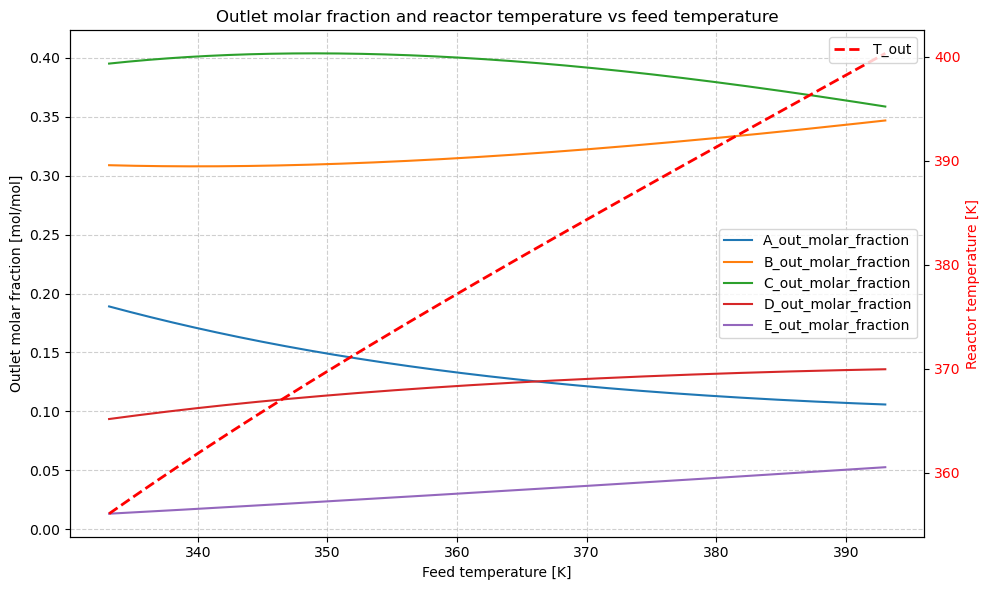

In [70]:
cols_to_plot = [
    'A_out_molar_fraction', 
    'B_out_molar_fraction', 
    'C_out_molar_fraction', 
    'D_out_molar_fraction', 
    'E_out_molar_fraction'
]

fig, ax1 = plt.subplots(figsize=(10, 6))

for col in cols_to_plot:
    ax1.plot(results_task2['feed_temperature'], results_task2[col], label=col)
ax1.set_xlabel("Feed temperature [K]")
ax1.set_ylabel("Outlet molar fraction [mol/mol]")
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
ax2.plot(results_task2['feed_temperature'], results_task2['T_out'], 'r--', linewidth=2, label='T_out')
ax2.set_ylabel("Reactor temperature [K]", color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center right')
ax2.legend(loc='upper right')

plt.title("Outlet molar fraction and reactor temperature vs feed temperature")
plt.tight_layout()
plt.show()

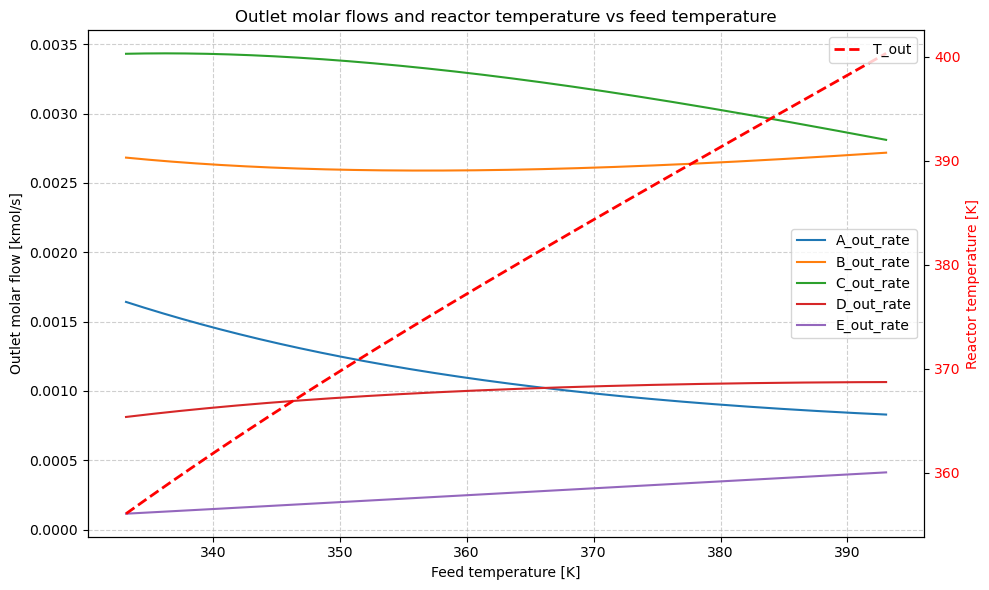

In [71]:
cols_to_plot = ['A_out_rate', 'B_out_rate', 'C_out_rate', 'D_out_rate', 'E_out_rate']

fig, ax1 = plt.subplots(figsize=(10, 6))

for col in cols_to_plot:
    ax1.plot(results_task2['feed_temperature'], results_task2[col], label=col)
ax1.set_xlabel("Feed temperature [K]")
ax1.set_ylabel("Outlet molar flow [kmol/s]")
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
ax2.plot(results_task2['feed_temperature'], results_task2['T_out'], 'r--', linewidth=2, label='T_out')
ax2.set_ylabel("Reactor temperature [K]", color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center right')
ax2.legend(loc='upper right')

plt.title("Outlet molar flows and reactor temperature vs feed temperature")
plt.tight_layout()
plt.show()

### Isothermal operation

Determine the **coolant temperature** required for **isothermal operation** under the following conditions:

$
m_{cat} = 1 \, \text{kg}, \quad T_{in} = 333.15 \, \text{K}
$


In [72]:
# Data and assumptions
m_catalist = 1.0
T_in = 333.15

For this task, we introduce a new function designed to determine the **coolant temperature** that ensures **isothermal operation** of the reactor.

Conceptually, this function acts like a *nested Matryoshka doll*: inside it, the full system of **material** and **energy balances** is solved for a given coolant temperature.  
However, at this outer level, our goal is much simpler — we are not trying to satisfy all balances directly.  
Instead, we seek the coolant temperature for which the **outlet temperature** becomes **equal** to the **inlet temperature**.

In other words, the residual that this function returns is:

$$
r^{\text{iso}} = T_{\text{out}} - T_{\text{in}}
$$

and this condition defines the **isothermal operating point** of the reactor.

In [73]:
def find_isothermal_conditions(T_cool, m_cat, stoch_matrix, F_in, T_in, U, x0, cat_capacity):
    """
    Evaluate the temperature deviation for a given coolant temperature in a non-isothermal CSTR.

    This function solves the coupled system of material and energy balances for a fixed
    coolant temperature (T_cool) using `fsolve`. It returns the deviation between the
    reactor outlet temperature (T_out) and the feed temperature (T_in). The root of this
    function (i.e., when T_out ≈ T_in) corresponds to **isothermal operating conditions**.

    Parameters

    T_cool : float
        Coolant (jacket) temperature [K].
    m_cat : float
        Catalyst mass [kg].
    stoch_matrix : ndarray, shape (5, 3)
        Stoichiometric matrix (components x reactions).
    F_in : ndarray, shape (5,)
        Inlet molar flow rates of components [kmol/s].
    T_in : float
        Feed temperature [K].
    U : float
        Overall heat transfer coefficient multiplied by heat exchange area [W/K].
    x0 : ndarray, shape (4,)
        Initial guess for [ξ₁, ξ₂, ξ₃, T].
    cat_capacity : float
        Catalyst active site concentration [kmol_active_sites/kg].

    Returns

    residual : ndarray, shape (1,)
        Temperature deviation between reactor outlet and feed: [T_out - T_in].
        The root (≈0) represents isothermal reactor operation.

    Notes

    - Internally calls `cstr_equations_extents`, which couples material and heat balances.
    - Designed to be used as an objective function for solvers such as `fsolve` or `least_squares`
      when determining the coolant temperature required for isothermal operation.
    - Typical usage:
        >>> fsolve(find_isothermal_conditions, x0=[280.0], args=(...))
    """
    T_cool = float(T_cool)

    sol, info, ier, msg = fsolve(
        func=cstr_equations_extents,
        x0=x0,
        args=(F_in, stoch_matrix, m_cat, cat_capacity, T_cool, T_in, U),
        xtol=1e-8,
        maxfev=5000,
        full_output=True
    )

    T_out = sol[3]
    return np.array([T_out - T_in])

Alright, now let’s go ahead and **solve for the isothermal coolant temperature** using the function we just defined.  

In [74]:
# Initial guess for the inner solver: [ξ₁, ξ₂, ξ₃, T]

x0_extents = np.array([0.0, 0.0, 0.0, 300.0], dtype=float)

# Initial guess for the coolant (jacket) temperature
T_cool_guess = np.array([313.0])

# Outer solver: find the coolant temperature that makes the reactor isothermal

sol_Tcool, info, ier, msg = fsolve(
    func=find_isothermal_conditions,         
    x0=T_cool_guess,                          
    args=(m_catalist, stoch_matrix, F_in, T_in, U, x0_extents, cat_capacity),
    xtol=1e-8,                                 
    full_output=True,                         
    maxfev=100                                 
)

# Extract and display the calculated isothermal coolant temperature
T_cool_isoterm = sol_Tcool[0]
print(f"\nIsothermal coolant temperature: {T_cool_isoterm:.2f} K")

/var/folders/ng/8s28f89j1671sbvj2qxq4lym0000gn/T/ipykernel_64572/1043107708.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_cool = float(T_cool)



Isothermal coolant temperature: 246.57 K


In the previous step, we obtained the **coolant temperature** corresponding to **isothermal operation**. At this point, we can only *trust* this computed value — but it would be wise to **verify** it independently.

In fact, we can approach this problem from a completely different perspective: rather than solving it numerically through nested solvers, we can explore it in a **simpler, more visual, and intuitive way — using a graphical analysis**.

In this step, we iterate over a range of **coolant temperatures** and solve the coupled **material** and **energy balances** for each case. This allows us to observe how the **reactor outlet temperature** varies with the **coolant temperature**.

Once all solutions are obtained, we plot the resulting relationship $T_{\text{out}}(T_{\text{cool}})$.  
The point where this curve **intersects the horizontal line** corresponding to the **feed temperature** $T_{\text{in}}$  
represents the **isothermal operating point** — the condition under which $T_{\text{out}} = T_{\text{in}}$.

In [75]:
# Range of coolant temperatures to test
cooling_temperatures = np.arange(230, 260, 0.1)

# Initial guess for [ξ1, ξ2, ξ3, T]
x0_extents = np.array([0.0, 0.0, 0.0, 300.0], dtype=float)

# DataFrame to store results
results_task3 = pd.DataFrame(
    columns=['cool_T', 'A_out', 'B_out', 'C_out', 'D_out', 'E_out', 'T_out']
)

# Loop over coolant temperatures
for T_cool in cooling_temperatures:

    # Solve the CSTR balances (material + energy)
    sol, info, ier, msg = fsolve(
        func=cstr_equations_extents,
        x0=x0_extents,
        args=(F_in, stoch_matrix, m_catalist, cat_capacity, T_cool, T_in, U),
        xtol=1e-8,
        maxfev=5000,
        full_output=True
    )

    # Extract solution
    xi = sol[:3]
    T  = float(sol[3])

    # Reconstruct outlet molar flows
    F_out = F_in + stoch_matrix @ xi
    A_out, B_out, C_out, D_out, E_out = F_out

    # Diagnostics
    res_norm = np.linalg.norm(info['fvec'])
    total = max(F_out.sum(), 1e-16)
    x_mf = np.clip(F_out / total, 1e-12, 1.0)
    x_mf /= x_mf.sum()
    r_test = reaction_rate(x_mf, T)

    # Print iteration summary
    print(f"T_cool={T_cool:.2f} K  ||res||={res_norm:.3e}  "
          f"T={T:.2f} K  rates={r_test}")

    # Save results
    results_task3.loc[len(results_task3)] = [
        T_cool, A_out, B_out, C_out, D_out, E_out, T
    ]

    # Warm start for the next iteration
    x0_extents = sol.copy()
    x0_extents[3] = float(np.clip(x0_extents[3], 250.0, 800.0))

T_cool=230.00 K  ||res||=7.390e-12  T=320.73 K  rates=[0.30056586 0.05661421 0.00155755]
T_cool=230.10 K  ||res||=1.530e-13  T=320.81 K  rates=[0.30096109 0.05683041 0.00157033]
T_cool=230.20 K  ||res||=1.638e-13  T=320.89 K  rates=[0.30135603 0.05704706 0.00158319]
T_cool=230.30 K  ||res||=1.703e-13  T=320.96 K  rates=[0.30175067 0.05726417 0.00159614]
T_cool=230.40 K  ||res||=1.628e-13  T=321.04 K  rates=[0.30214501 0.05748174 0.00160918]
T_cool=230.50 K  ||res||=1.598e-13  T=321.12 K  rates=[0.30253905 0.05769975 0.0016223 ]
T_cool=230.60 K  ||res||=1.704e-13  T=321.19 K  rates=[0.30293279 0.05791821 0.00163551]
T_cool=230.70 K  ||res||=1.639e-13  T=321.27 K  rates=[0.30332622 0.05813712 0.0016488 ]
T_cool=230.80 K  ||res||=1.620e-13  T=321.35 K  rates=[0.30371934 0.05835648 0.00166219]
T_cool=230.90 K  ||res||=1.730e-13  T=321.42 K  rates=[0.30411215 0.05857628 0.00167566]
T_cool=231.00 K  ||res||=1.759e-13  T=321.50 K  rates=[0.30450465 0.05879653 0.00168923]
T_cool=231.10 K  ||re

In [76]:
results_task3

,cool_T,A_out,B_out,C_out,D_out,E_out,T_out
0,230.0,0.003067,0.003358,0.002723,0.000275,0.000008,320.731374
1,230.1,0.003064,0.003356,0.002725,0.000276,0.000008,320.808346
2,230.2,0.003061,0.003354,0.002728,0.000277,0.000008,320.885304
3,230.3,0.003058,0.003352,0.002731,0.000278,0.000008,320.962248
4,230.4,0.003055,0.003350,0.002734,0.000279,0.000008,321.039177
...,...,...,...,...,...,...,...
295,259.5,0.002173,0.002881,0.003304,0.000607,0.000050,342.058599
296,259.6,0.002170,0.002880,0.003305,0.000608,0.000051,342.124068
297,259.7,0.002167,0.002878,0.003306,0.000609,0.000051,342.189483
298,259.8,0.002165,0.002877,0.003307,0.000610,0.000051,342.254843


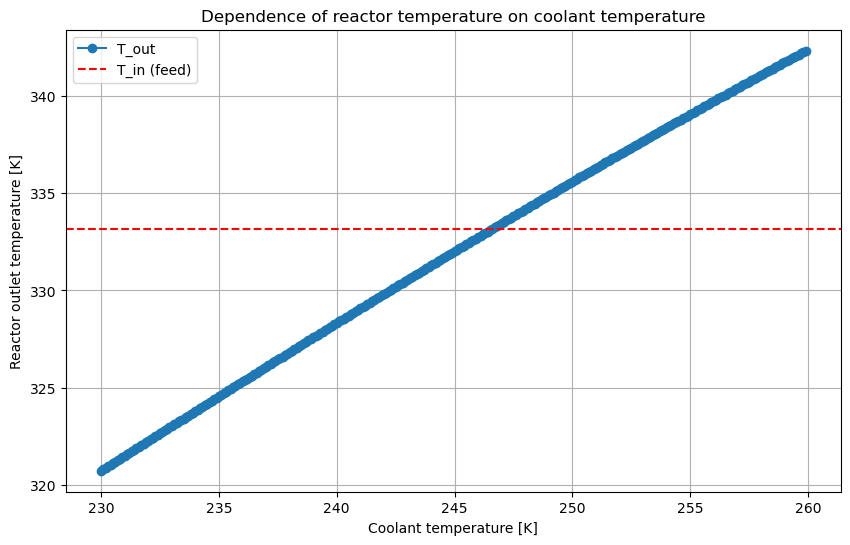

In [77]:
plt.figure(figsize=(10,6))
plt.plot(results_task3['cool_T'], results_task3['T_out'], 'o-', label='T_out')
plt.axhline(T_in, color='r', linestyle='--', label='T_in (feed)')
plt.xlabel("Coolant temperature [K]")
plt.ylabel("Reactor outlet temperature [K]")
plt.title("Dependence of reactor temperature on coolant temperature")
plt.legend()
plt.grid(True)
plt.show()

If this intersection occurs at the same coolant temperature as previously found numerically, it confirms that our earlier solver-based approach was **accurate** and the model behaves **consistently**.

### Final Remarks

The key takeaways from this assignment are as follows:

- Always aim to **reduce the number of equations** in your system whenever possible.  
  Reformulating the problem in terms of **reaction extents** instead of component balances significantly improves solvability.

- Choose **appropriate solvers** for the problem type (e.g., `fsolve` for root-finding or `least_squares` for robust nonlinear least-squares problems).

- Apply **proper scaling (normalization)** to all quantities — especially when variables differ by several orders of magnitude.  
  This is essential for achieving **numerical stability** and ensuring smooth solver convergence.

- Provide a **physically meaningful initial guess**.  
  A poor starting point may lead to divergence or unrealistic results, even for a correct model.

- Always perform **sanity checks**:  
  verify physical trends, validate consistency between mass and energy balances, and check whether results are reasonable from a process engineering standpoint.

Overall, the exercise demonstrates how careful formulation, scaling, and interpretation are critical for successful **reactor modeling and simulation** using numerical methods.